## File transfer in Google colab

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.mkdir('cropped images')

In [ ]:
from shutil import copyfile
src = '/content/gdrive/MyDrive/Xccelerate/capstone/cropped images whole.zip'
dst = '/content/cropped images/cropped_images.zip'
copyfile(src, dst)

'/content/cropped images/cropped_images.zip'

In [ ]:
from shutil import copyfile
src = '/content/gdrive/MyDrive/Xccelerate/capstone/cropped_image_whole.csv'
dst = '/content/cropped_image_whole.csv'
copyfile(src, dst)

'/content/cropped_image_whole.csv'

In [ ]:
os.chdir('cropped images')
os.getcwd()

'/content/cropped images'

In [ ]:
!unzip cropped_images.zip

In [ ]:
os.remove('cropped_images.zip')

In [ ]:
os.chdir('..')

## Loading images

In [33]:
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import BatchNormalization, Lambda, Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.layers.merge import Concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [22]:
import pandas as pd
df = pd.read_csv('cropped_image_whole.csv', index_col=0)
df.head()

,image_name,image_color
0,img_0.jpg,White
1,img_2.jpg,White
2,img_3.jpg,White
3,img_4.jpg,Black
4,img_5.jpg,Black


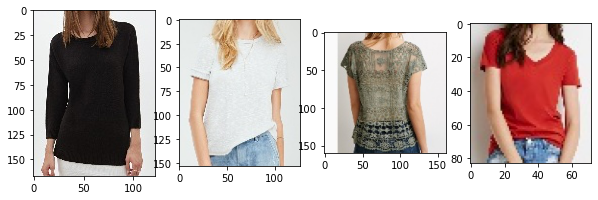

In [51]:
fig, axes = plt.subplots(1,4, figsize=(10,8))
choices = random.choices(range(df.shape[0]), k=4)
for x in range(len(choices)):
    path = 'cropped images/' + df.iloc[choices[x],0]

    # done by cv2
    # img = cv2.imread(path)
    # axes[x].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    # done by keras
    img = image.load_img(path)
    axes[x].imshow(img)

plt.show()

C:\Users\NP950XBE-X01HK\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


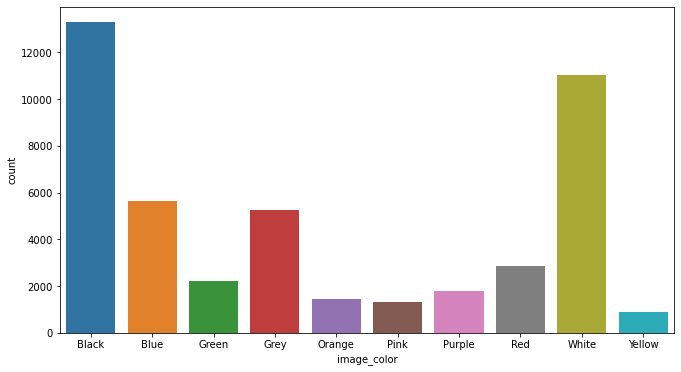

In [3]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# %matplotlib inline
# plt.figure(figsize=(11,6))
# sns.countplot(df['image_color'], order=['Black', 'Blue', 'Green', 'Grey', 'Orange', 'Pink', 'Purple', 'Red', 'White', 'Yellow'])
# plt.show()

In [5]:
# from sklearn.utils import class_weight
# target = df['image_color']
# cw = dict(zip(np.unique(target), class_weight.compute_class_weight('balanced', np.unique(target), target)))
# cw

{'Black': 0.3447279295552043,
 'Blue': 0.8089720946661957,
 'Green': 2.0466487935656836,
 'Grey': 0.8698063045955184,
 'Orange': 3.13296853625171,
 'Pink': 3.4516955538809344,
 'Purple': 2.566050420168067,
 'Red': 1.6032201610080503,
 'White': 0.41560656927683515,
 'Yellow': 5.094994438264739}

In [3]:
img_rows , img_cols = 227,227
num_classes = 10
batch_size = 32

In [4]:
datagen = ImageDataGenerator(rescale=1./255,
                             shear_range=0.2,
                             zoom_range=0.3,
                             horizontal_flip=True, 
                             validation_split=0.2)

datagen_valid = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [5]:
train_gen = datagen.flow_from_dataframe(dataframe=df, directory='data/In-shop/cropped images',
                                       x_col='image_name', y_col='image_color', class_mode='categorical',
                                       target_size=(img_rows,img_cols), batch_size=batch_size, 
                                        subset='training')

valid_gen = datagen_valid.flow_from_dataframe(dataframe=df, directory='data/In-shop/cropped images',
                                       x_col='image_name', y_col='image_color', class_mode='categorical',
                                       target_size=(img_rows,img_cols), batch_size=batch_size, 
                                       subset='validation')

Found 36644 validated image filenames belonging to 10 classes.
Found 9160 validated image filenames belonging to 10 classes.


In [6]:
STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

# **Final training**

In [7]:
def color_net(num_classes):
    
    input_image = Input(shape=(227,227,3))
    
# Top base
    # 1st layer
    top_conv1 = Conv2D(filters=48,kernel_size=11,strides=4, 
                       input_shape=(227,227,3),activation='relu')(input_image)
    top_conv1 = BatchNormalization()(top_conv1)
    top_conv1 = MaxPooling2D(pool_size=3,strides=2)(top_conv1)

    # 2nd leyer, splitting by half
    top_a_conv2 = Lambda(lambda x : x[:,:,:,:24])(top_conv1)
    top_b_conv2 = Lambda(lambda x : x[:,:,:,24:])(top_conv1)

    top_a_conv2 = Conv2D(filters=64,kernel_size=3,strides=1,activation='relu',padding='same')(top_a_conv2)
    top_a_conv2 = BatchNormalization()(top_a_conv2)
    top_a_conv2 = MaxPooling2D(pool_size=3,strides=2)(top_a_conv2)

    top_b_conv2 = Conv2D(filters=64,kernel_size=3,strides=1,activation='relu',padding='same')(top_b_conv2)
    top_b_conv2 = BatchNormalization()(top_b_conv2)
    top_b_conv2 = MaxPooling2D(pool_size=3,strides=2)(top_b_conv2)

    # 3rd layer, concat the previous 2 halves
    top_conv3 = Concatenate()([top_a_conv2,top_b_conv2])
    top_conv3 = Conv2D(filters=192,kernel_size=3,strides=1,activation='relu',padding='same')(top_conv3)

    # 4th layer, splitting by half
    top_a_conv4 = Lambda(lambda x : x[:,:,:,:96])(top_conv3)
    top_b_conv4 = Lambda(lambda x : x[:,:,:,96:])(top_conv3)

    top_a_conv4 = Conv2D(filters=96,kernel_size=3,strides=1,activation='relu',padding='same')(top_a_conv4)
    top_b_conv4 = Conv2D(filters=96,kernel_size=3,strides=1,activation='relu',padding='same')(top_b_conv4)

    # 5th layer
    top_a_conv5 = Conv2D(filters=64,kernel_size=3,strides=1,activation='relu',padding='same')(top_a_conv4)
    top_a_conv5 = MaxPooling2D(pool_size=3,strides=2)(top_a_conv5) 

    top_b_conv5 = Conv2D(filters=64,kernel_size=3,strides=1,activation='relu',padding='same')(top_b_conv4)
    top_b_conv5 = MaxPooling2D(pool_size=3,strides=2)(top_b_conv5)

# Bottom base
    # 1st layer
    bot_conv1 = Conv2D(filters=48,kernel_size=11,strides=4, 
                       input_shape=(227,227,3),activation='relu')(input_image)
    bot_conv1 = BatchNormalization()(bot_conv1)
    bot_conv1 = MaxPooling2D(pool_size=3,strides=2)(bot_conv1)

    # 2nd layer, splitting by half
    bot_a_conv2 = Lambda(lambda x : x[:,:,:,:24])(bot_conv1)
    bot_b_conv2 = Lambda(lambda x : x[:,:,:,24:])(bot_conv1)

    bot_a_conv2 = Conv2D(filters=64,kernel_size=3,strides=1,activation='relu',padding='same')(bot_a_conv2)
    bot_a_conv2 = BatchNormalization()(bot_a_conv2)
    bot_a_conv2 = MaxPooling2D(pool_size=3,strides=2)(bot_a_conv2)

    bot_b_conv2 = Conv2D(filters=64,kernel_size=3,strides=1,activation='relu',padding='same')(bot_b_conv2)
    bot_b_conv2 = BatchNormalization()(bot_b_conv2)
    bot_b_conv2 = MaxPooling2D(pool_size=3,strides=2)(bot_b_conv2)

    # 3rd layer, concat the previous 2 halves
    bot_conv3 = Concatenate()([bot_a_conv2,bot_b_conv2])
    bot_conv3 = Conv2D(filters=192,kernel_size=3,strides=1,activation='relu',padding='same')(bot_conv3)

    # 4th layer, splitting by half
    bot_a_conv4 = Lambda(lambda x : x[:,:,:,:96])(bot_conv3)
    bot_b_conv4 = Lambda(lambda x : x[:,:,:,96:])(bot_conv3)

    bot_a_conv4 = Conv2D(filters=96,kernel_size=3,strides=1,activation='relu',padding='same')(bot_a_conv4)
    bot_b_conv4 = Conv2D(filters=96,kernel_size=3,strides=1,activation='relu',padding='same')(bot_b_conv4)

    # fifth bottom convolution layer
    bot_a_conv5 = Conv2D(filters=64,kernel_size=3,strides=1,activation='relu',padding='same')(bot_a_conv4)
    bot_a_conv5 = MaxPooling2D(pool_size=3,strides=2)(bot_a_conv5) 

    bot_b_conv5 = Conv2D(filters=64,kernel_size=3,strides=1,activation='relu',padding='same')(bot_b_conv4)
    bot_b_conv5 = MaxPooling2D(pool_size=3,strides=2)(bot_b_conv5)

# Concat top and bottom bases
    conv_output = Concatenate()([top_a_conv5,top_b_conv5,bot_a_conv5,bot_b_conv5])

    # Flatten
    flatten = Flatten()(conv_output)

    # Fully-connected layer
    FC_1 = Dense(units=4096, activation='relu')(flatten)
    FC_1 = Dropout(0.6)(FC_1)
    FC_2 = Dense(units=4096, activation='relu')(FC_1)
    FC_2 = Dropout(0.6)(FC_2)
    output = Dense(num_classes, activation='softmax')(FC_2)
    
    model = Model(inputs=input_image,outputs=output)
    sgd = SGD(lr=1e-2, decay=1e-5)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

    
    return model

In [8]:
model = color_net(num_classes)

In [54]:
from sklearn.utils import class_weight

target = df['image_color'].map(train_gen.class_indices)
cw = dict(zip(np.unique(target), class_weight.compute_class_weight('balanced', np.unique(target), target)))
cw

{0: 0.3447279295552043,
 1: 0.8089720946661957,
 2: 2.0466487935656836,
 3: 0.8698063045955184,
 4: 3.13296853625171,
 5: 3.4516955538809344,
 6: 2.566050420168067,
 7: 1.6032201610080503,
 8: 0.41560656927683515,
 9: 5.094994438264739}

In [ ]:
# run time: Dec17 11am
# sgd = SGD(lr=1e-2, decay=1e-5)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
hist = model.fit_generator(generator=train_gen, steps_per_epoch=STEP_SIZE_TRAIN, 
                validation_data=valid_gen, validation_steps=STEP_SIZE_VALID,
                epochs=50, class_weight=cw, callbacks=early_stop)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
1317/1317 [==============================] - 460s 349ms/step - loss: 1.3949 - accuracy: 0.5425 - precision: 0.7036 - recall: 0.3282 - val_loss: 1.5879 - val_accuracy: 0.4093 - val_precision: 0.4276 - val_recall: 0.1883
Epoch 2/50
1317/1317 [==============================] - 457s 347ms/step - loss: 1.0998 - accuracy: 0.6334 - precision: 0.7443 - recall: 0.4786 - val_loss: 1.0751 - val_accuracy: 0.6525 - val_precision: 0.7859 - val_recall: 0.4415
Epoch 3/50
1317/1317 [==============================] - 457s 347ms/step - loss: 1.0073 - accuracy: 0.6575 - precision: 0.7576 - recall: 0.5277 - val_loss: 1.2421 - val_accuracy: 0.5261 - val_precision: 0.7227 - val_recall: 0.4137
Epoch 4/50
1317/1317 [==============================] - 458s 348ms/step - loss: 0.9674 - accuracy: 0.6701 - precision: 0.7636 - recall: 0.5519 - val_loss: 1.0365 - val_accuracy: 0.6619 - val_precision: 0.7768 - val_recall: 0.4995
Epoc

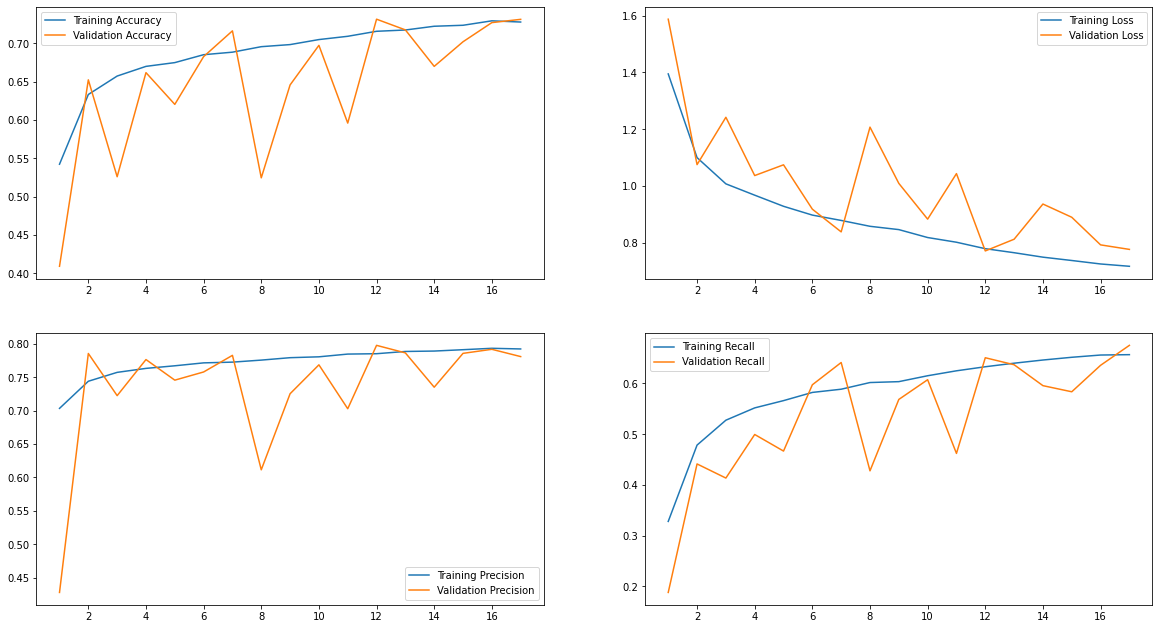

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(2,2, figsize=(20,11))
epoch_list = list(range(1, len(hist.history['accuracy']) + 1))
axes[0,0].plot(epoch_list, hist.history['accuracy'], epoch_list, hist.history['val_accuracy'])
axes[0,0].legend(('Training Accuracy', 'Validation Accuracy'))
axes[0,1].plot(epoch_list, hist.history['loss'], epoch_list, hist.history['val_loss'])
axes[0,1].legend(('Training Loss', 'Validation Loss'))
axes[1,0].plot(epoch_list, hist.history['precision'], epoch_list, hist.history['val_precision'])
axes[1,0].legend(('Training Precision', 'Validation Precision'))
axes[1,1].plot(epoch_list, hist.history['recall'], epoch_list, hist.history['val_recall'])
axes[1,1].legend(('Training Recall', 'Validation Recall'))
plt.show()

In [ ]:
from pathlib import Path
model_structure = model.to_json()
f = Path("color_model_Dec17.json")
f.write_text(model_structure)

model.save_weights('color_model_Dec17.h5')


from shutil import copyfile
src = '/content/color_model_Dec17.json'
dst = '/content/gdrive/MyDrive/Xccelerate/capstone/models/color_model_Dec17.json'
copyfile(src, dst)

src = '/content/color_model_Dec17.h5'
dst = '/content/gdrive/MyDrive/Xccelerate/capstone/models/color_model_Dec17.h5'
copyfile(src, dst)

'/content/gdrive/MyDrive/Xccelerate/capstone/models/color_model_Dec17.h5'